## Set up the environment

In [1]:
import pandas as pd
import numpy as np
import os
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm
import multiprocessing
from sklearn.neural_network import MLPRegressor

sns.set_style('darkgrid')
cwd = os.getcwd()
print(cwd)

C:\Users\dleszk01


In [2]:
## helper functions

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

## Load the data

In [3]:
df=pd.read_csv(r'C:\Users\dleszk01\prywatne\IMDB Dataset.csv\IMDB Dataset.csv')
df.head()

,review,sentiment
0,An excellent cast who do their best with an aw...,negative
1,A dreary and pointless bit of fluff (bloody fl...,negative
2,If the writer/director is reading this (and I ...,negative
3,This is a classic B type movie that you'd rath...,negative
4,A short review but...<br /><br />Avoid at all ...,negative


## Preprocessing

- Remove non-digit and non-letter parts

- Remove stop words (but keep the word 'from')

- Remove standalone numbers (remove '100' from '100 pieces')

- Any other text cleaning and standard processing

In [4]:
# Check null values
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [5]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27502 entries, 0 to 27501
Data columns (total 2 columns):
review       27502 non-null object
sentiment    27502 non-null object
dtypes: object(2)
memory usage: 429.8+ KB


In [6]:
# Transform reviews to lowercase
df['review_clean'] = df['review'].astype(str).copy()
df['review_clean'] = df['review_clean'].map(lambda x: x.lower())

### Remove non-digit and non-letter parts

In [7]:
df['review_clean'] = df['review_clean'].map(lambda x: re.sub('[^a-zA-Z0-9|\s]+', '', x))

df.head()

,review,sentiment,review_clean
0,An excellent cast who do their best with an aw...,negative,an excellent cast who do their best with an aw...
1,A dreary and pointless bit of fluff (bloody fl...,negative,a dreary and pointless bit of fluff bloody flu...
2,If the writer/director is reading this (and I ...,negative,if the writerdirector is reading this and i im...
3,This is a classic B type movie that you'd rath...,negative,this is a classic b type movie that youd rathe...
4,A short review but...<br /><br />Avoid at all ...,negative,a short review butbr br avoid at all costs a t...


### Remove standalone numbers (remove '100' from '100 pieces')

In [8]:
df['review_clean'] = df['review_clean'].map(lambda x:re.sub(r'\s*\d+\s*', ' ', x))

df.head()

,review,sentiment,review_clean
0,An excellent cast who do their best with an aw...,negative,an excellent cast who do their best with an aw...
1,A dreary and pointless bit of fluff (bloody fl...,negative,a dreary and pointless bit of fluff bloody flu...
2,If the writer/director is reading this (and I ...,negative,if the writerdirector is reading this and i im...
3,This is a classic B type movie that you'd rath...,negative,this is a classic b type movie that youd rathe...
4,A short review but...<br /><br />Avoid at all ...,negative,a short review butbr br avoid at all costs a t...


### Remove stop words (but keep the word 'from')

In [9]:
# load raw stopwords
stop_words = stopwords.words('english')

# Remove 'from' from stopwords
stop_words.remove('from')

# Make sure that stopwords do not contain 'from' word
print('from' in stop_words)

df['review_clean'] = df['review_clean'].map(lambda x:' '.join([word for word in x.split() if word not in (stop_words)]))

df.head()

False


,review,sentiment,review_clean
0,An excellent cast who do their best with an aw...,negative,excellent cast best awful script inept directi...
1,A dreary and pointless bit of fluff (bloody fl...,negative,dreary pointless bit fluff bloody fluff fluff ...
2,If the writer/director is reading this (and I ...,negative,writerdirector reading imagine since work must...
3,This is a classic B type movie that you'd rath...,negative,classic b type movie youd rather waste time se...
4,A short review but...<br /><br />Avoid at all ...,negative,short review butbr br avoid costs thorough was...


### EDA

Generating a WordCloud of positive reviews...
Generating a WordCloud of negative reviews...


<Figure size 432x288 with 0 Axes>

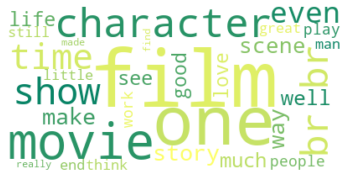

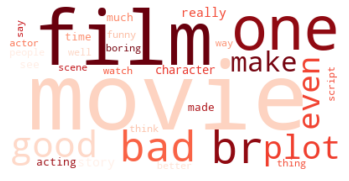

In [10]:
# Generate wordclouds of positive and negative reviews for exploratory purposes and identification of potential stopwords

color_dict = {'positive': 'summer', 'negative':'Reds'}

plt.figure()

for sent in ['positive', 'negative']:
    
    print(f'Generating a WordCloud of {sent} reviews...')
    
    # Join the different processed titles together.
    long_string = ','.join(list(df.loc[df['sentiment']==sent]['review_clean'].values))

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=30, colormap = color_dict[sent])

    # Generate a WordCloud 
    wordcloud.generate(long_string)

    # Visualize the word cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

# br is a commonly appearing word which is rubbish information for the algorithm. Let's remove this word from reviews
df['review_clean'] = df['review_clean'].map(lambda x: re.sub('br', '', x))


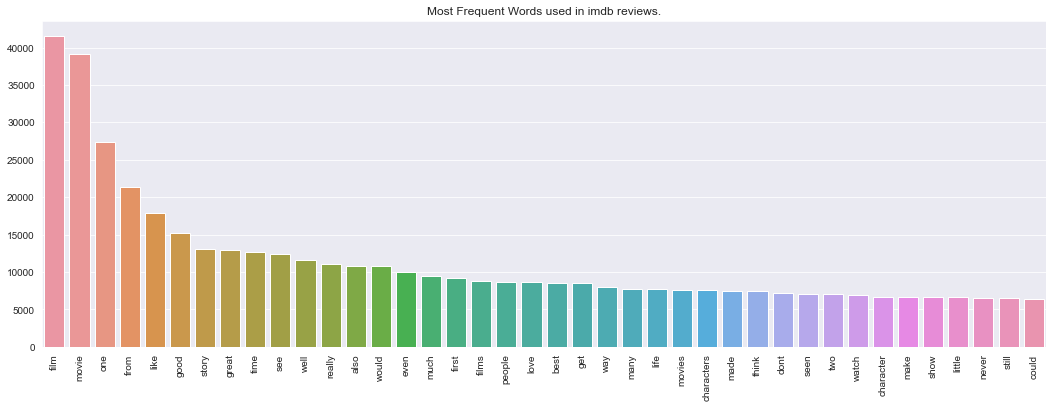

In [11]:
# Explore most common words

aggregate_counter = Counter()
for row_index,row in pd.DataFrame(df['review_clean']).iterrows():
    c = Counter(row['review_clean'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(40)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(40)]

barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in imdb reviews.')

### Any other text cleaning and standard processing

In [12]:
# Remove empty string reviews
df = df.loc[df['review_clean']!='', :].reset_index(drop=True)

# Replace double spaces with single spaces
df['review_clean'] = df['review_clean'].map(lambda x:re.sub(' {2,}', ' ', x))

# Apply Lemmatization
df['review_tokens'] = df['review_clean'].map(lambda x:x.split())
lemmatizer = WordNetLemmatizer() 
df['review_tokens'] = df['review_tokens'].apply(lambda lst:[lemmatizer.lemmatize(word) for word in lst])
df['review_lemmatized'] = df['review_tokens'].apply(lambda x:' '.join(x))

df.head()

,review,sentiment,review_clean,review_tokens,review_lemmatized
0,An excellent cast who do their best with an aw...,negative,excellent cast best awful script inept directi...,"[excellent, cast, best, awful, script, inept, ...",excellent cast best awful script inept directi...
1,A dreary and pointless bit of fluff (bloody fl...,negative,dreary pointless bit fluff bloody fluff fluff ...,"[dreary, pointless, bit, fluff, bloody, fluff,...",dreary pointless bit fluff bloody fluff fluff ...
2,If the writer/director is reading this (and I ...,negative,writerdirector reading imagine since work must...,"[writerdirector, reading, imagine, since, work...",writerdirector reading imagine since work must...
3,This is a classic B type movie that you'd rath...,negative,classic b type movie youd rather waste time se...,"[classic, b, type, movie, youd, rather, waste,...",classic b type movie youd rather waste time se...
4,A short review but...<br /><br />Avoid at all ...,negative,short review but avoid costs thorough waste mi...,"[short, review, but, avoid, cost, thorough, wa...",short review but avoid cost thorough waste min...


### Explore topics mentioned in the reviews

In [13]:
# Prepare the data for topic modelling
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df['review_lemmatized'])

# Tweak the two parameters below
number_topics = 20
number_words = 15

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
zombie custer flynn one errol scott horse from fido dead hospital david corbett welles john

Topic #1:
film one great movie scene good best performance from role story well also make character

Topic #2:
film character also best from performance man one role great tarzan story scene like year

Topic #3:
opera betty andrew film soap bed nurse argento carmen oliver tony love dana murder dixon

Topic #4:
movie one film like good really time see great get think dont from would watch

Topic #5:
from one film performance play get time best good actor story also great western role

Topic #6:
film movie well character story good one from like love plot actor action much acting

Topic #7:
one film from reynolds time camp burt game lena also woman story two friend star

Topic #8:
song dance musical marie from film streisand astaire concert fred music singing rogers ginger one

Topic #9:
from episode one series show time character see like first people story also 

## Build a classifier

- Target variable is 'sentiment', build a classifier and assess its performance

### 1) First classifier to be tested is Random Forest

In [14]:
# Transform target variable to dummy variable
df['sentiment'] = [1 if x == 'positive' else 0 for x in df['sentiment']]

In [15]:
# Prepare text corpus for training
corpus=[]

for rev in df['review_lemmatized']:
    corpus.append(rev)
    

In [16]:
# Transform text data into a numeric format (TF IDF matrix)
vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8)
processed_features = vectorizer.fit_transform(corpus).toarray()

In [17]:
processed_features.shape

(27502, 2500)

In [18]:
# Split data onto train and test sets
labels = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [19]:
# Train and cross validate the estimator

clf = RandomForestClassifier(n_estimators=64, random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='f1')

print(scores)

rf_score = scores.mean()

print(f'Average F1 Score of Random Forest classifier equals: {np.round(rf_score,2)}')

[0.97561453 0.97466001 0.97280376 0.97433386]
Average F1 Score of Random Forest classifier equals: 0.97


### 2) Second classifier to be tested is XGBoost

In [20]:
# Train and cross validate the estimator

from sklearn.model_selection import cross_val_score

clf = xgb.XGBClassifier(objective="binary:logistic", random_state=0)
scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='f1')

print(scores)

xgb_score = scores.mean()

print(f'Average F1 Score of XGBoost classifier equals: {np.round(xgb_score,2)}')

[0.97873182 0.97961203 0.97844998 0.97813829]
Average F1 Score of XGBoost classifier equals: 0.98


##### Since we pay attention to the accuracy of predictions of both, positive and negative labels, F1 Score is selected as a metric decisive of which model should be chosen. This being said, XGBoost slightly outperformed Random Forest classifier in analyzed use-case with cross-validated F1 Score of 0.98.

# Anomaly detection on "review" column

## An anomaly in a set of text reviews can be considered in terms of the:
1) Extreme review length (extremely short; extremely long reviews)

2) Reviews content (reviews containing least common words; reviews NOT containing most common words)

### Find extremely short/long reviews

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 7 Text major ticklabel objects>)

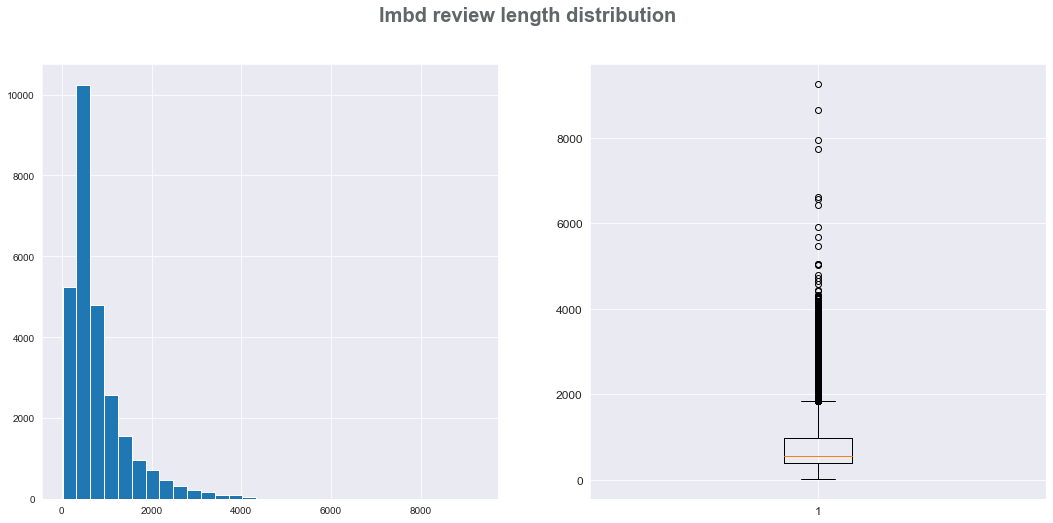

In [21]:
# Explore distribution of review length
df['review_length'] = df['review_clean'].apply(lambda x:len(x))


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
fig.suptitle('Imbd review length distribution', fontsize=20, fontweight='bold', color='#626667')
ax1.hist(df['review_length'], bins=30)
ax2.boxplot(df['review_length'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [22]:
# Based on above visualizations, we conclude that reviews that have less than 200 characters or more than 2000 characters are 
# anomalies

In [23]:
df['length_anomaly']=0
df.loc[(df['review_length']<200)|(df['review_length']>2000), 'length_anomaly']=1

print(f"The dataset contains {df['length_anomaly'].value_counts().loc[1]} extremelly short or long reviews")
      

The dataset contains 3729 extremelly short or long reviews


### Find reviews that do not contain most popular words

In [24]:
df['popularword_anomaly']=0

df['popularword_anomaly']=pd.Series(df['review_clean'].apply(lambda x:any(item in x.split() for item in common_words)))

print(f"The dataset contains {df['popularword_anomaly'].value_counts().loc[False]} reviews that do not contain 40 most common words")


The dataset contains 36 reviews that do not contain 40 most common words


### Find reviews that contain least popular words

In [28]:
# prepare a list of least common words
uncommon_words=[word[0] for word in aggregate_counter.most_common()]
uncommon_words.reverse()
uncommon_words=uncommon_words[:40]

df['unpoppularword_anomaly']=0

df['unpoppularword_anomaly']=pd.Series(df['review_clean'].apply(lambda x:any(item in x.split() for item in uncommon_words)))

print(f"The dataset contains {df['unpoppularword_anomaly'].value_counts().loc[True]} reviews that contain 40 most uncommon words")


The dataset contains 28 reviews that contain 40 most uncommon words
